## Time Series Regression


In [1]:
# version 1.2
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myBasic.R")
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myPreprocessing.R")
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myTSRegression.R")

## Dataset for exploring
Some parameters are fixed but can be explored. 
TSNormalization used is ts_gminmax(), but other normalizations are available.

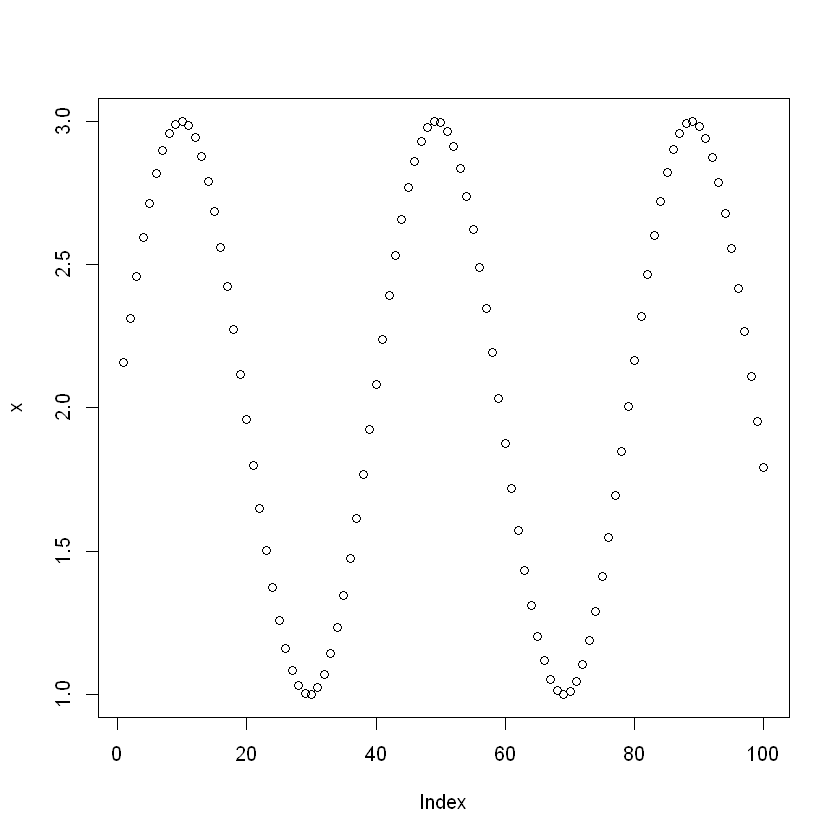

In [2]:
load_series <- function(name) {
  link <- url(sprintf("https://raw.githubusercontent.com/eogasawara/mylibrary/master/data/time-series/%s.RData", name))
  x <- get(load(link))
  return(x)  
}
x <- load_series("sin")
sahead <- 1
tsize <- 1
swsize <- 10
preproc <- ts_gminmax()
plot(x)


## General function for testing regression methods

In [3]:
train_test <- function(x, model, sw, test_size, steps_ahead) {
  ts <- ts_data(x, sw)
  
  samp <- ts_sample(ts, test_size)

  io_train <- ts_projection(samp$train)

  model <- prepare(model, x=io_train$input, y=io_train$output)
  
  adjust <- action(model, io_train$input)
  ev_adjust <- evaluation.tsreg(io_train$output, adjust)
  print(head(ev_adjust$metrics))

  io_test <- ts_projection(samp$test)
  
  prediction <- action(model, io_test$input)
  ev_prediction <- evaluation.tsreg(io_test$output, prediction)
  print(head(ev_prediction$metrics))
  
  print(sprintf("%s %.2f", class(model)[1], 100*ev_prediction$metrics$smape))
  
  plot(model, y=c(io_train$output, io_test$output), yadj=adjust, ypre=prediction)
  
  return(model)
}

## ARIMA (baseline)

tsreg_arima,prepare.tsreg_arima,0.004,



        mse      smape
1 0.0123684 0.05188252
        mse      smape
1 0.0257263 0.08558225
[1] "tsreg_arima 8.56"


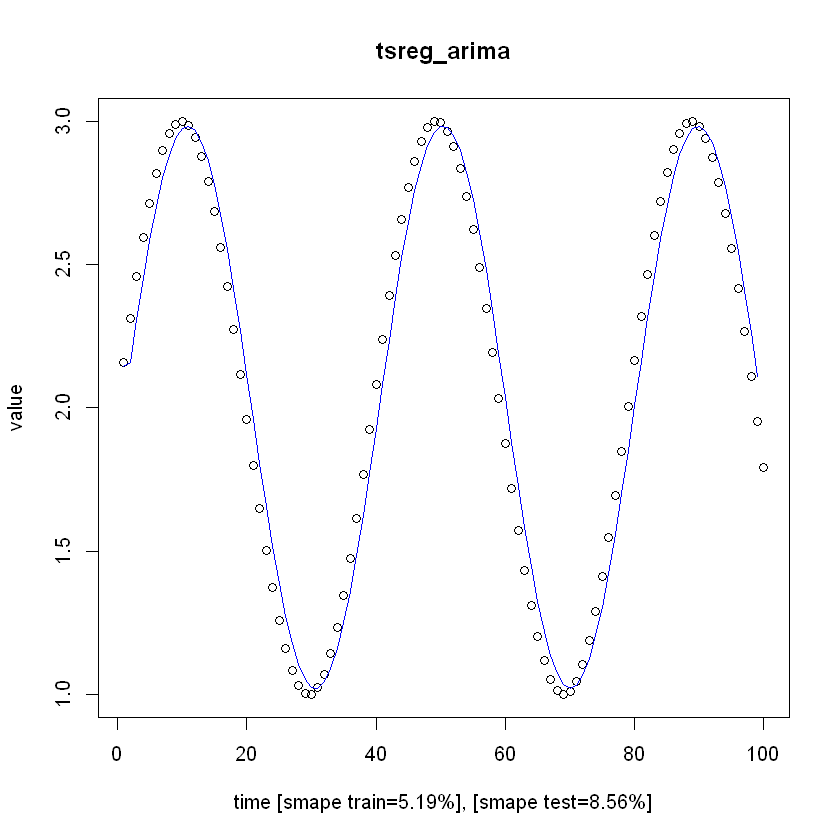

In [8]:
model <- train_test(x, model=tsreg_arima(), 0, 
           test_size = tsize, steps_ahead = sahead)

## Random Forest

Warning message in rfout$mse/(var(y) * (n - 1)/n):
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
tsreg_rf,prepare.tsreg_sw,0.000,mtry=3,ntree=50



         mse      smape
1 0.00217001 0.02093969
          mse      smape
1 0.005588891 0.04082207
[1] "tsreg_rf 4.08"


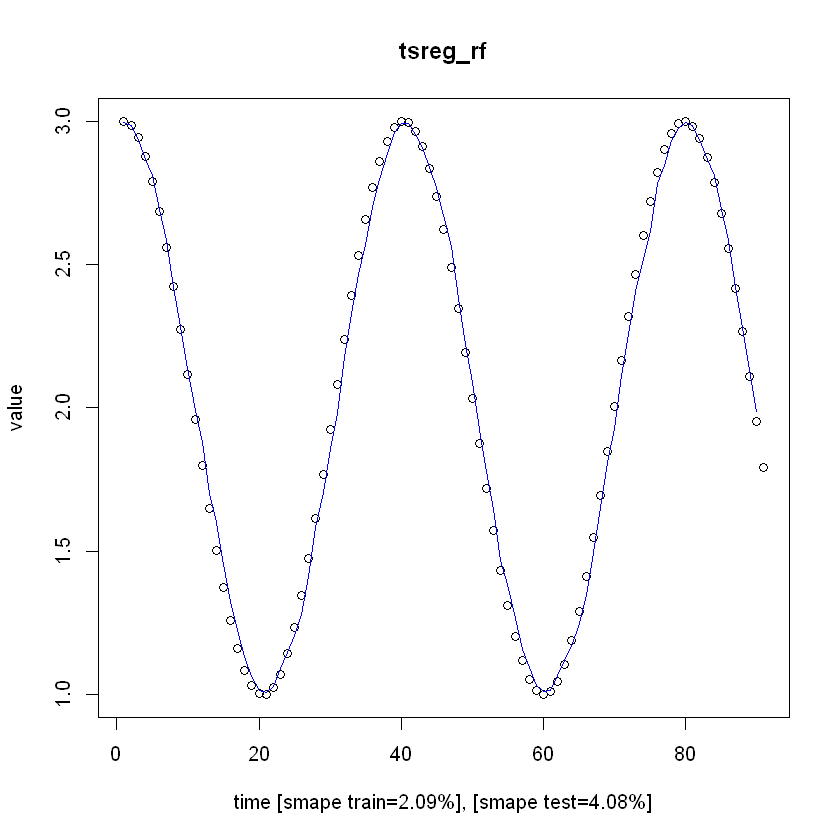

In [12]:
# do not set mtry and ntree for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_rf(preproc, input_size=4, mtry=3, ntree=50), 
                    sw = swsize, test_size = tsize, steps_ahead = sahead)

## Neural Networks - MLP

Warning message in rfout$mse/(var(y) * (n - 1)/n):
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
tsreg_rf,prepare.tsreg_sw,0.001,mtry=3,ntree=50



         mse      smape
1 0.00217001 0.02093969
          mse      smape
1 0.005588891 0.04082207
[1] "tsreg_rf 4.08"


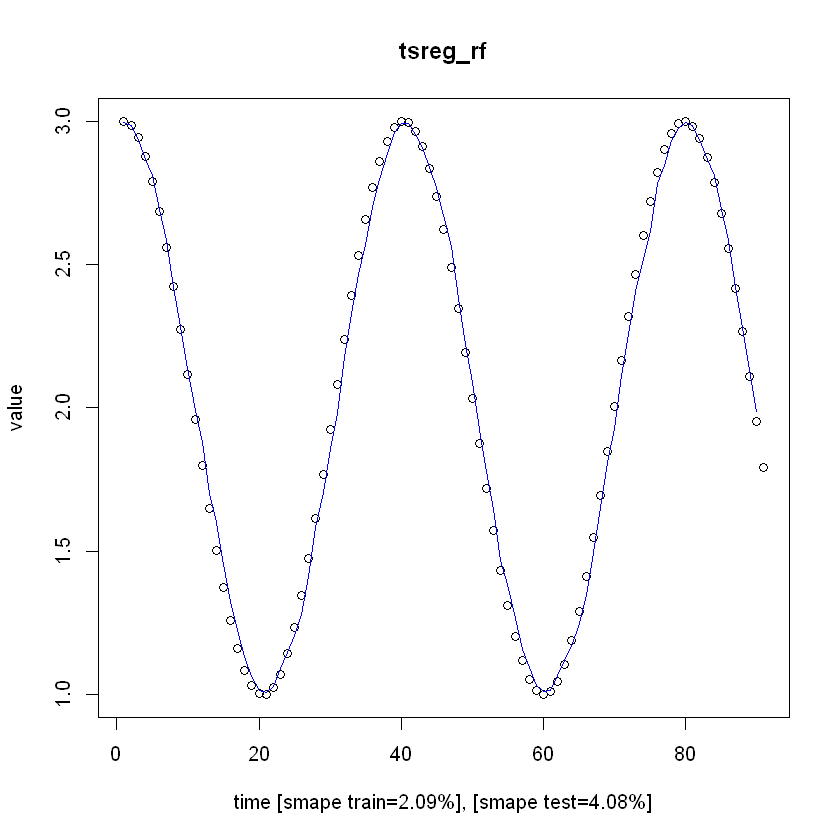

In [9]:
# do not set decay and set a range for neurons for hyperparameter optimization
# you can also set a range for them
  model <- train_test(x, model=tsreg_rf(preproc, input_size=4, mtry=3, ntree=50), 
             sw = swsize, test_size = tsize, steps_ahead = sahead)

## SVM


Loading required package: e1071

tsreg_svm,prepare.tsreg_sw,0.002,epsilon=0.0,cost=80.000



           mse        smape
1 2.954775e-08 7.680232e-05
          mse        smape
1 7.28081e-08 0.0001504218
[1] "tsreg_svm 0.02"


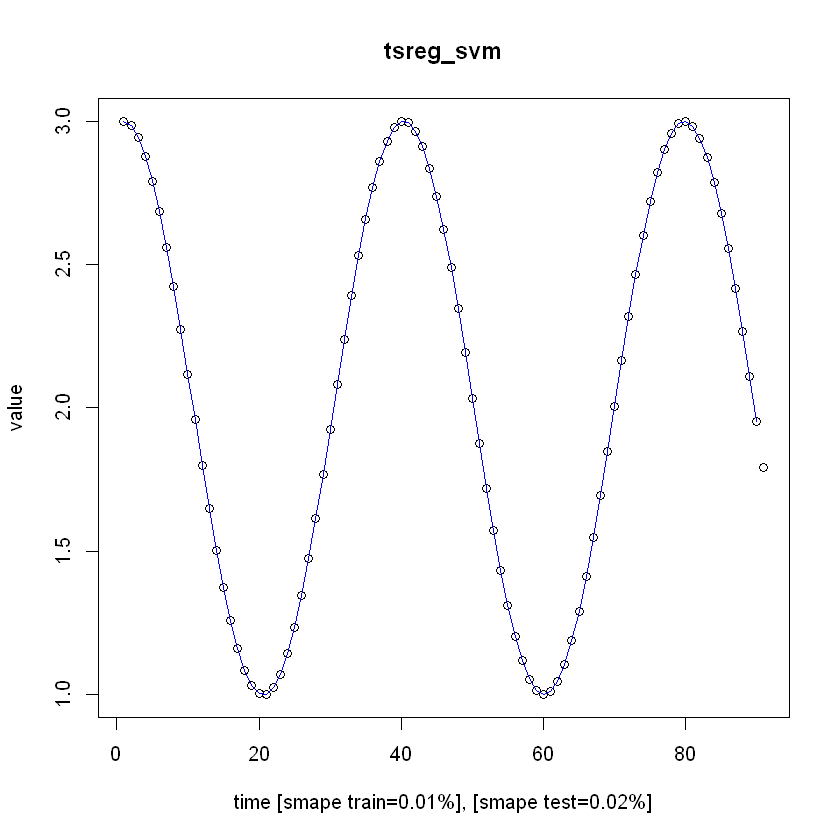

In [10]:
#do not set epsilon, cost, and  kernel for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_svm(preproc, input_size=4, epsilon=0.0, cost=80.00), 
           sw = swsize, test_size = tsize, steps_ahead = sahead)

## ELM

tsreg_elm,prepare.tsreg_sw,0.001,nhid=3,actfun=purelin



           mse        smape
1 2.551746e-29 1.769572e-15
           mse        smape
1 5.369185e-29 4.084534e-15
[1] "tsreg_elm 0.00"


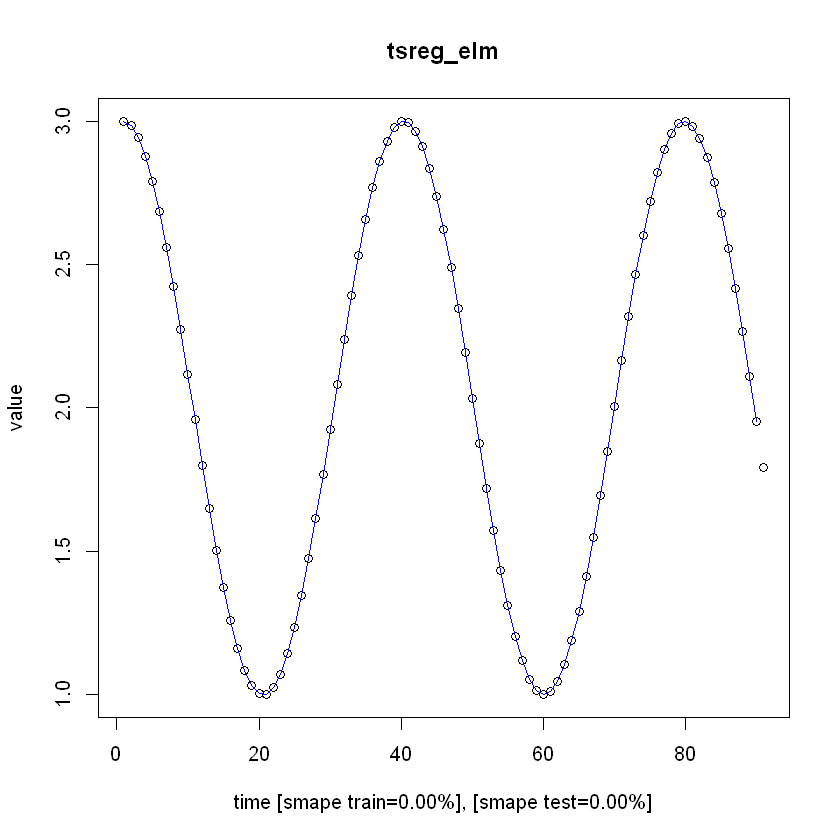

In [14]:
#do not set nhid and actfun for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_elm(preproc, input_size=4, nhid=3,actfun="purelin"), 
           sw = swsize, test_size = tsize, steps_ahead = sahead)

## Convolutional neural networks (CNN)

Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: tensorflow


Attaching package: 'tensorflow'


The following objects are masked from 'package:TSPred':

    evaluate, train


Loading required package: keras


Attaching package: 'keras'


The following object is masked _by_ '.GlobalEnv':

    normalize


The following object is masked from 'package:TSPred':

    evaluate


Loading required package: tfdatasets

tsreg_cnn,prepare.tsreg_sw,0.201,neurons=16,epochs=200



          mse      smape
1 0.001299792 0.01988402
           mse        smape
1 1.813155e-06 0.0007503138
[1] "tsreg_cnn 0.08"


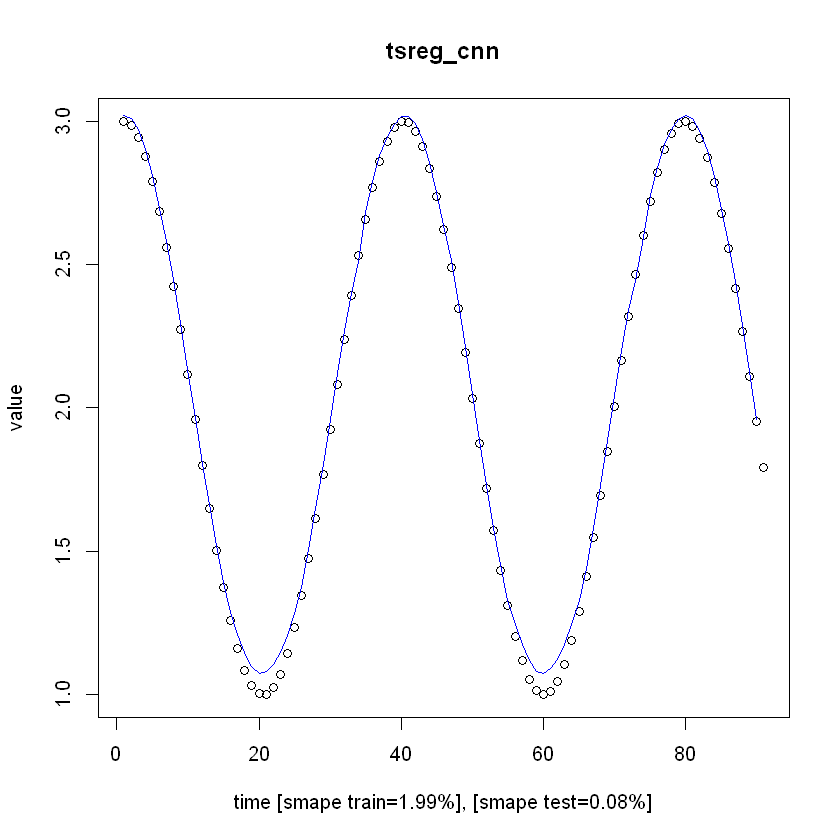

In [15]:
# do not set neurons and epochs for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_cnn(preproc, input_size=4, neurons=16,epochs=200), 
           sw = swsize, test_size = tsize, steps_ahead = sahead)

## Long short-term memory (LSTM)

tsreg_lstm,prepare.tsreg_sw,1.213,neurons=32,epochs=200



          mse    smape
1 0.007051856 0.043011
          mse      smape
1 0.001891959 0.02395581
[1] "tsreg_lstm 2.40"


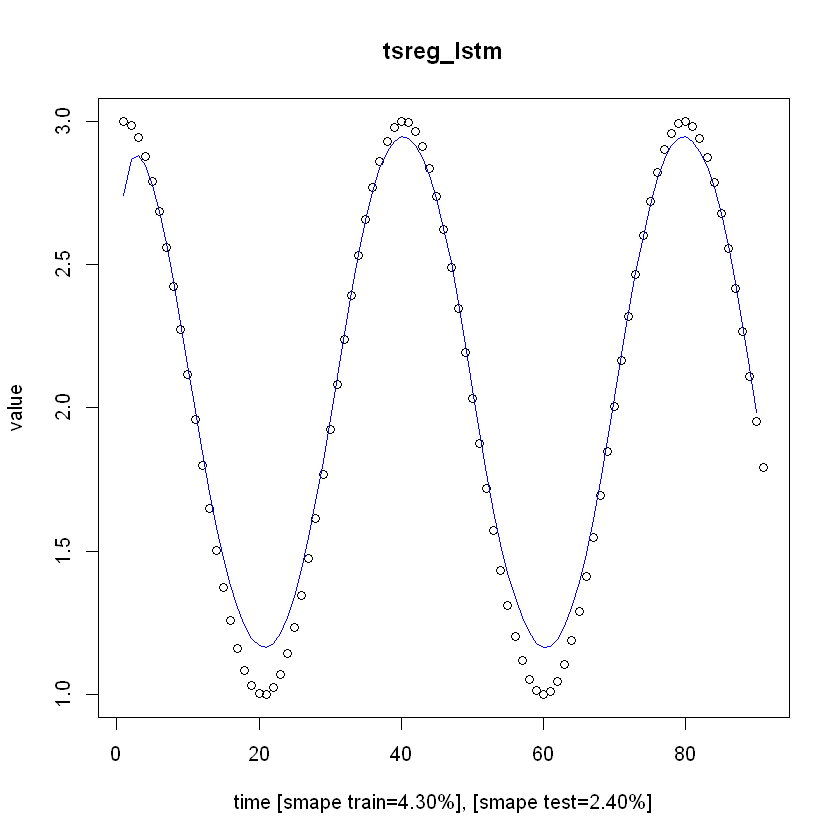

In [17]:
# do not set neurons and epochs for hyperparameter optimization
# you can also set a range for them
model <- train_test(x, model=tsreg_lstm(preproc, input_size=4, neurons=32, epochs=200), 
                    sw = swsize, test_size = tsize, steps_ahead = sahead)